# GIN Experiment
This notebook will implement the evaluation pipeline with the FID calculation using the GIN

## Setup

In [1]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pickle
from tqdm import tqdm

from util import load_data, load_synth_data, separate_data , load_graph_asS2Vgraph
from models.graphcnn import GraphCNN


criterion = nn.CrossEntropyLoss()

In [2]:
def train(iters_per_epoch, batch_size, model, device, train_graphs, optimizer, epoch):
    model.train()

    total_iters = iters_per_epoch
    pbar = tqdm(range(total_iters), unit='batch')

    loss_accum = 0
    for pos in pbar:
        selected_idx = np.random.permutation(len(train_graphs))[:batch_size]

        batch_graph = [train_graphs[idx] for idx in selected_idx]
        output = model(batch_graph)

        labels = torch.LongTensor([graph.label for graph in batch_graph]).to(device)

        #compute loss
        loss = criterion(output, labels)

        #backprop
        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()         
            optimizer.step()
        

        loss = loss.detach().cpu().numpy()
        loss_accum += loss

        #report
        pbar.set_description('epoch: %d' % (epoch))

    average_loss = loss_accum/total_iters
    print("loss training: %f" % (average_loss))
    
    return average_loss

###pass data to model with minibatch during testing to avoid memory overflow (does not perform backpropagation)
def pass_data_iteratively(model, graphs, minibatch_size = 64):
    model.eval()
    output = []
    idx = np.arange(len(graphs))
    for i in range(0, len(graphs), minibatch_size):
        sampled_idx = idx[i:i+minibatch_size]
        if len(sampled_idx) == 0:
            continue
        output.append(model([graphs[j] for j in sampled_idx]).detach())
    return torch.cat(output, 0)

def test(model, device, train_graphs, test_graphs, epoch):
    model.eval()

    output = pass_data_iteratively(model, train_graphs)
    pred = output.max(1, keepdim=True)[1]
    labels = torch.LongTensor([graph.label for graph in train_graphs]).to(device)
    correct = pred.eq(labels.view_as(pred)).sum().cpu().item()
    acc_train = correct / float(len(train_graphs))

    output = pass_data_iteratively(model, test_graphs)
    pred = output.max(1, keepdim=True)[1]
    labels = torch.LongTensor([graph.label for graph in test_graphs]).to(device)
    correct = pred.eq(labels.view_as(pred)).sum().cpu().item()
    acc_test = correct / float(len(test_graphs))

    print("accuracy train: %f test: %f" % (acc_train, acc_test))

    return acc_train, acc_test

## Training settings

In [3]:
dataset = None
device = 0 
batch_size = 32
iters_per_epoch = 50
epochs = 60
lr = 0.01
seed = 0
fold_idx = 1
num_layers = [5]
num_mlp_layers = 3
hidden_dims = [64]
final_dropout = 0.5
graph_pooling_type = "sum"
neighbor_pooling_type = "sum"
learn_eps = False
degree_as_tag = True
filename = ""
random = 1

## Training 

In [4]:
from itertools import product

train_acc,test_acc=[],[]

#set up seeds and gpu device
torch.manual_seed(0)
np.random.seed(0)    
device = torch.device("cuda:" + str(device)) if torch.cuda.is_available() else torch.device("cpu")
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

if dataset != None :
    graphs, num_classes = load_data(dataset, degree_as_tag)
else :
    graphs, num_classes, tagset , lentagset = load_synth_data(True, random)

for num_layer,hidden_dim in product(num_layers,hidden_dims):
    fold_test_accuracy=[]
    fold_train_accuracy=[]
    for fold_idx in range(1,2):
        train_graphs, test_graphs = separate_data(graphs, seed, fold_idx)

        model = GraphCNN(num_layer, num_mlp_layers, train_graphs[0].node_features.shape[1], hidden_dim, num_classes, final_dropout, learn_eps, graph_pooling_type, neighbor_pooling_type,random, device).to(device)

        optimizer = optim.Adam(model.parameters(),lr=lr)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
        
        for epoch in range(1, epochs + 1):
            scheduler.step()

            avg_loss = train(iters_per_epoch,batch_size,model, device, train_graphs, optimizer, epoch)
            acc_train, acc_test = test( model, device, train_graphs, test_graphs, epoch)
            fold_test_accuracy.append(acc_test)
            fold_train_accuracy.append(acc_train)
    train_acc.append((np.mean(fold_train_accuracy),num_layer,hidden_dim))
    test_acc.append((np.mean(fold_test_accuracy),num_layer,hidden_dim))

loading data
# classes: 1
# maximum node tag: 3
# data: 500


/home/ousmanetouat/anaconda3/envs/graphRL/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
epoch: 1: 100%|██████████| 50/50 [00:03<00:00, 14.92batch/s]


loss training: 0.000000
accuracy train: 1.000000 test: 1.000000


epoch: 2: 100%|██████████| 50/50 [00:02<00:00, 16.86batch/s]


loss training: 0.000000
accuracy train: 1.000000 test: 1.000000


epoch: 3: 100%|██████████| 50/50 [00:02<00:00, 17.15batch/s]


loss training: 0.000000
accuracy train: 1.000000 test: 1.000000


epoch: 4: 100%|██████████| 50/50 [00:03<00:00, 16.32batch/s]


loss training: 0.000000
accuracy train: 1.000000 test: 1.000000


epoch: 5: 100%|██████████| 50/50 [00:02<00:00, 16.79batch/s]


loss training: 0.000000
accuracy train: 1.000000 test: 1.000000


epoch: 6:   0%|          | 0/50 [00:00<?, ?batch/s]

In [ ]:
output = pass_data_iteratively(model, graphs)

In [ ]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

/home/ousmanetouat/anaconda3/envs/graphRL/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(<Figure size 576x576 with 1 Axes>,
 [Text(-0.942225,-7.85306,'0'),
  Text(-49.7159,-1.64681,'1'),
  Text(15.0845,44.5278,'2'),
  Text(55.249,-2.59657,'3'),
  Text(-1.52742,-59.5839,'4')])

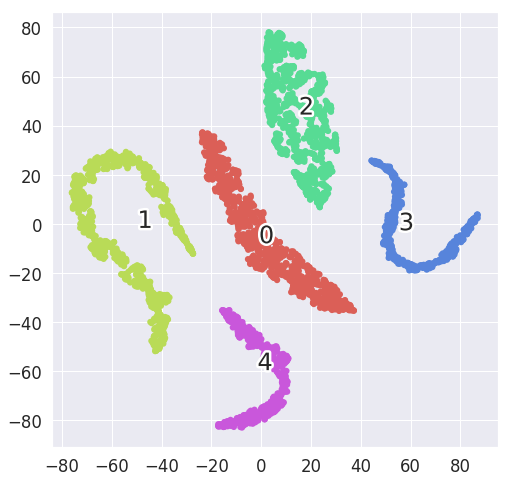

In [ ]:
X=output.cpu()
y = np.array([g.label for g in graphs])
############################################################
from sklearn.manifold import TSNE
import time
time_start = time.time()

fashion_tsne = TSNE(random_state=0).fit_transform(X)
fashion_scatter(fashion_tsne, y)

In [ ]:
np.unique(y)

array([0, 1, 2, 3, 4])

In [ ]:
import networkx as nx
from scipy import linalg
## Coming from https://github.com/mseitzer/pytorch-fid
def compute_FID(mu1, mu2, cov1, cov2, eps = 1e-6):
    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert cov1.shape == cov2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2
    # Product might be almost singular
    covmean, _ = linalg.sqrtm(cov1.dot(cov2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
                'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(cov1.shape[0]) * eps
        covmean = linalg.sqrtm((cov1 + offset).dot(cov2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(cov1) +
            np.trace(cov2) - 2 * tr_covmean)

def compute_fid(ref_graph,ref_label,pred_graph,model):
    device = 0
    num_layers = 5
    num_mlp_layers = 2
    hidden_dim = 64
    final_dropout = 0.5
    graph_pooling_type = "sum"
    neighbor_pooling_type = "sum"
    learn_eps = False
    
    #set up seeds and gpu device
    torch.manual_seed(0)
    np.random.seed(0)
    device = torch.device("cuda:" + str(device)) if torch.cuda.is_available() else torch.device("cpu")
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(0)
    #model = GraphCNN(num_layers, num_mlp_layers, train_graphs[0].node_features.shape[1], hidden_dim, 5, final_dropout, learn_eps, graph_pooling_type, neighbor_pooling_type, 'cpu').to('cpu')
    #model.load_checkpoint()
    #model.eval()


    with torch.no_grad():
        embed_graphs_ref = model.get_graph_embed_sum(ref_graph)
        embed_graphs_ref=embed_graphs_ref.cpu().detach().numpy()
        mu_ref = np.mean(embed_graphs_ref, axis = 0)
        cov_ref = np.cov(embed_graphs_ref, rowvar = False)

        embed_graphs_pred = model.get_graph_embed_sum(pred_graph)
        embed_graphs_pred=embed_graphs_pred.cpu().detach().numpy()
        mu_pred = np.mean(embed_graphs_pred, axis = 0)
        cov_pred = np.cov(embed_graphs_pred, rowvar = False)

    fid = compute_FID(mu_ref,mu_pred,cov_ref,cov_pred)
    return fid

def test_acc(model, device, train_graphs):
    model.eval()

    output = pass_data_iteratively(model, train_graphs)
    pred = output.max(1, keepdim=True)[1]
    labels = torch.LongTensor([graph.label for graph in train_graphs]).to(device)
    correct = pred.eq(labels.view_as(pred)).sum().cpu().item()
    acc = float(correct / float(len(train_graphs)))


    print("accuracy : %f" % (acc))

    return acc

In [ ]:
from util import load_graph_list
graph_grid_test=load_graph_list('saved_graphs/grid_test.p',False)
graph_grid_gen=load_graph_list('../../generated_graphs/grid_GRANMixtureBernoulli_DFS.p',False)
graph2= []
npr = np.random.RandomState(1)
npr.shuffle(graph_grid_test)
graph_grid_test=graph_grid_test[:100]
for k in range(10,20):
    for j in range(10,20):
        graph2.append(nx.grid_2d_graph(k,j))
graph_grid_gen_rnn=load_graph_list('../../generated_graphs/grid_RNN_BFS.p',False)
graph_grid_gen_mlp=load_graph_list('../../generated_graphs/grid_RNN_MLP_BFS.p',False)
g_list_ref,_ = load_graph_asS2Vgraph(graph_grid_test,4,random,tagset , lentagset)
g_list_pred,_ = load_graph_asS2Vgraph(graph_grid_gen,4,random, tagset , lentagset)
g_list_pred2,_ = load_graph_asS2Vgraph(graph2,4,random, tagset , lentagset)
g_list_pred_rnn,_ = load_graph_asS2Vgraph(graph_grid_gen_rnn,4,random, tagset , lentagset)
g_list_pred_mlp,_ = load_graph_asS2Vgraph(graph_grid_gen_mlp,4,random, tagset , lentagset)
print(compute_fid([graphs[i] for i in range(len(graphs)) if graphs[i].label ==1],2,g_list_pred2,model))
print(compute_fid([graphs[i] for i in range(len(graphs)) if graphs[i].label ==1],2,g_list_pred,model))
print(compute_fid([graphs[i] for i in range(len(graphs)) if graphs[i].label ==1],2,g_list_pred_rnn,model))
print(compute_fid([graphs[i] for i in range(len(graphs)) if graphs[i].label ==1],2,g_list_pred_mlp,model))
test_acc(model,'cuda:0',[graphs[i] for i in range(len(graphs)) if graphs[i].label ==1])
test_acc(model,'cuda:0',g_list_pred)
test_acc(model,'cuda:0',g_list_pred_rnn)
test_acc(model,'cuda:0',g_list_pred_mlp)

# classes: 1
# maximum node tag: 3
# data: 100
# classes: 1
# maximum node tag: 4
# data: 100
# classes: 1
# maximum node tag: 3
# data: 100
# classes: 1
# maximum node tag: 8
# data: 100
# classes: 1
# maximum node tag: 8
# data: 100
35.35968009468888
4014.4102485260646
26027.419415881854
65476.91343120941
accuracy : 1.000000
accuracy : 1.000000
accuracy : 1.000000
accuracy : 0.930000


0.93

In [ ]:
graph_ba_test=load_graph_list('saved_graphs/barabasi_test.p',False)
npr = np.random.RandomState(1)
npr.shuffle(graph_ba_test)
graph_ba_test=graph_ba_test[:10]
graph_ba_gen_dd=load_graph_list('../../generated_graphs/barabasi_GRANMixtureBernoulli_degree_decent.p',False)
graph_ba_gen_bfs=load_graph_list('../../generated_graphs/barabasi_GRANMixtureBernoulli_BFS.p',False)
graph_ba_gen_dfs=load_graph_list('../../generated_graphs/barabasi_GRANMixtureBernoulli_DFS.p',False)
graph_ba_gen_kcore=load_graph_list('../../generated_graphs/barabasi_GRANMixtureBernoulli_k_core.p',False)
graph_ba_gen_noorder=load_graph_list('../../generated_graphs/barabasi_GRANMixtureBernoulli_no_order.p',False)
graph_ba_regen=[]
for i in range(100,200):
    for j in range(5):
        g=nx.barabasi_albert_graph(i,4)
        graph_ba_regen.append(g)
g_list_ref_ba,_ = load_graph_asS2Vgraph(graph_ba_test,2,random, tagset , lentagset)
g_list_ref_ba_regen,_ = load_graph_asS2Vgraph(graph_ba_regen,2,random, tagset , lentagset)
g_list_ref_ba_dd,_ = load_graph_asS2Vgraph(graph_ba_gen_dd,2,random, tagset , lentagset)
g_list_ref_ba_bfs,_ = load_graph_asS2Vgraph(graph_ba_gen_bfs,2,random, tagset , lentagset)
g_list_ref_ba_dfs,_ = load_graph_asS2Vgraph(graph_ba_gen_dfs,2,random, tagset , lentagset)
g_list_ref_ba_kcore,_ = load_graph_asS2Vgraph(graph_ba_gen_kcore,2,random, tagset , lentagset)
g_list_ref_ba_no,_ = load_graph_asS2Vgraph(graph_ba_gen_noorder,2,random, tagset , lentagset)
print(compute_fid([graphs[i] for i in range(len(graphs)) if graphs[i].label ==2][:100],2,g_list_ref_ba_regen,model))
print(compute_fid([graphs[i] for i in range(len(graphs)) if graphs[i].label ==2][:100],2,g_list_ref_ba_dd,model))
print(compute_fid([graphs[i] for i in range(len(graphs)) if graphs[i].label ==2][:100],2,g_list_ref_ba_bfs,model))
print(compute_fid([graphs[i] for i in range(len(graphs)) if graphs[i].label ==2][:100],2,g_list_ref_ba_dfs,model))
print(compute_fid([graphs[i] for i in range(len(graphs)) if graphs[i].label ==2][:100],2,g_list_ref_ba_kcore,model))
print(compute_fid([graphs[i] for i in range(len(graphs)) if graphs[i].label ==2][:100],2,g_list_ref_ba_no,model))

test_acc(model,'cuda:0',g_list_ref_ba)
test_acc(model,'cuda:0',g_list_ref_ba_dd)
test_acc(model,'cuda:0',g_list_ref_ba_bfs)
test_acc(model,'cuda:0',g_list_ref_ba_dfs)
test_acc(model,'cuda:0',g_list_ref_ba_kcore)
test_acc(model,'cuda:0',g_list_ref_ba_no)

# classes: 1
# maximum node tag: 45
# data: 10
# classes: 1
# maximum node tag: 66
# data: 500
# classes: 1
# maximum node tag: 65
# data: 500
# classes: 1
# maximum node tag: 64
# data: 500
# classes: 1
# maximum node tag: 69
# data: 500
# classes: 1
# maximum node tag: 58
# data: 500
# classes: 1
# maximum node tag: 66
# data: 500
1016880.1972972867
1482377.276299108
650900.3113275735
5227228.469139386
822772.9403548855
9370804.800407553
accuracy : 0.000000
accuracy : 0.002000
accuracy : 0.000000
accuracy : 0.002000
accuracy : 0.004000
accuracy : 0.000000


0.0

In [ ]:
graph_ws_test=load_graph_list('saved_graphs/watts_test.p',False)
npr = np.random.RandomState(1)
npr.shuffle(graph_ws_test)
graph_ws_test=graph_ba_test[:500]
graph_ws_gen_dd=load_graph_list('../../generated_graphs/wattsSW_GRANMixtureBernoulli_degree_descent.p',False)
graph_ws_gen_bfs=load_graph_list('../../generated_graphs/wattsSW_GRANMixtureBernoulli_BFS.p',False)
graph_ws_gen_dfs=load_graph_list('../../generated_graphs/wattsSW_GRANMixtureBernoulli_DFS.p',False)
graph_ws_gen_kcore=load_graph_list('../../generated_graphs/wattsSW_GRANMixtureBernoulli_k_core.p',False)
graph_ws_gen_noorder=load_graph_list('../../generated_graphs/wattsSW_GRANMixtureBernoulli_no_order.p',False)
graph_ws_regen=[]
for i in range(100,200):
    for j in range(5):
        g=nx.watts_strogatz_graph(i,4,0.1)
        graph_ws_regen.append(g)
g_list_ref_ws,_ = load_graph_asS2Vgraph(graph_ws_test,1,random, tagset , lentagset)
g_list_ref_ws_regen,_ = load_graph_asS2Vgraph(graph_ws_regen,1,random, tagset , lentagset)
g_list_ref_ws_dd,_ = load_graph_asS2Vgraph(graph_ws_gen_dd,1,random, tagset , lentagset)
g_list_ref_ws_bfs,_ = load_graph_asS2Vgraph(graph_ws_gen_bfs,1,random, tagset , lentagset)
g_list_ref_ws_dfs,_ = load_graph_asS2Vgraph(graph_ws_gen_dfs,1,random, tagset , lentagset)
g_list_ref_ws_kcore,_ = load_graph_asS2Vgraph(graph_ws_gen_kcore,1,random, tagset , lentagset)
g_list_ref_ws_no,_ = load_graph_asS2Vgraph(graph_ws_gen_noorder,1,random, tagset , lentagset)
print(compute_fid(g_list_ref_ws,1,g_list_ref_ws_regen,model))
print(compute_fid(g_list_ref_ws,1,g_list_ref_ws_dd,model))
print(compute_fid(g_list_ref_ws,1,g_list_ref_ws_bfs,model))
print(compute_fid(g_list_ref_ws,1,g_list_ref_ws_dfs,model))
print(compute_fid(g_list_ref_ws,1,g_list_ref_ws_kcore,model))
print(compute_fid(g_list_ref_ws,1,g_list_ref_ws_no,model))

test_acc(model,'cuda:0',g_list_ref_ws)
test_acc(model,'cuda:0',g_list_ref_ws_dd)
test_acc(model,'cuda:0',g_list_ref_ws_bfs)
test_acc(model,'cuda:0',g_list_ref_ws_dfs)
test_acc(model,'cuda:0',g_list_ref_ws_kcore)
test_acc(model,'cuda:0',g_list_ref_ws_no)

# classes: 1
# maximum node tag: 67
# data: 500
# classes: 1
# maximum node tag: 7
# data: 500
# classes: 1
# maximum node tag: 16
# data: 500
# classes: 1
# maximum node tag: 29
# data: 500
# classes: 1
# maximum node tag: 10
# data: 500
# classes: 1
# maximum node tag: 10
# data: 500
# classes: 1
# maximum node tag: 25
# data: 500
7258120.195728873
7235047.506023419
3516124.148399424
7216705.166170676
7224543.672919266
7205840.056679942
accuracy : 1.000000
accuracy : 0.002000
accuracy : 0.032000
accuracy : 0.000000
accuracy : 0.000000
accuracy : 0.000000


0.0

In [ ]:
def n_community(c_sizes, p_inter=0.01):
    graphs = [nx.gnp_random_graph(c_sizes[i], 0.7, seed=i) for i in range(len(c_sizes))]
    G = nx.disjoint_union_all(graphs)
    communities = [G.subgraph(c) for c in nx.connected_components(G)]
    for i in range(len(communities)):
        subG1 = communities[i]
        nodes1 = list(subG1.nodes())
        for j in range(i + 1, len(communities)):
            subG2 = communities[j]
            nodes2 = list(subG2.nodes())
            has_inter_edge = False
            for n1 in nodes1:
                for n2 in nodes2:
                    if np.random.rand() < p_inter:
                        G.add_edge(n1, n2)
                        has_inter_edge = True
            if not has_inter_edge:
                G.add_edge(nodes1[0], nodes2[0])
    # print('connected comp: ', len(list(nx.connected_component_subgraphs(G))))
    return G

graph_com2_test=load_graph_list('saved_graphs/community2_test.p',False)
graph_com2_gen_dd=load_graph_list('../../generated_graphs/community2small_GRANMixtureBernoulli_DFS.p',False)
graph3=[]
for i in range(500):
    c_sizes = np.random.choice(list(range(12, 17)), 2)
    graph3.append(n_community(c_sizes, p_inter=0.05))
g_list_ref_com2,_ = load_graph_asS2Vgraph(graph_com2_test,3,random, tagset , lentagset)
g_list_pred_com2,_ = load_graph_asS2Vgraph(graph_com2_gen_dd,3,random, tagset , lentagset)
g_list_pred_com3,_ = load_graph_asS2Vgraph(graph3,3,random, tagset , lentagset)
print(compute_fid(g_list_ref_com2,1,g_list_pred_com2,model))
print(compute_fid(g_list_ref_com2,1,g_list_pred_com3,model))
test_acc(model,'cuda:0',g_list_ref_com2)
test_acc(model,'cuda:0',g_list_pred_com2)

# classes: 1
# maximum node tag: 15
# data: 1000
# classes: 1
# maximum node tag: 17
# data: 500
# classes: 1
# maximum node tag: 15
# data: 500
1159.5768720300985
1.5968673082034002
accuracy : 0.000000
accuracy : 0.000000


0.0

In [ ]:
def test_acc(model, device, train_graphs):
    model.eval()

    output = pass_data_iteratively(model, train_graphs)
    pred = output.max(1, keepdim=True)[1]
    labels = torch.LongTensor([graph.label for graph in train_graphs]).to(device)
    correct = pred.eq(labels.view_as(pred)).sum().cpu().item()
    acc = float(correct / float(len(train_graphs)))


    print("accuracy : %f" % (acc))

    return acc

def n_community(c_sizes, p_inter=0.01):
    graphs = [nx.gnp_random_graph(c_sizes[i], 0.7, seed=i) for i in range(len(c_sizes))]
    G = nx.disjoint_union_all(graphs)
    communities = [G.subgraph(c) for c in nx.connected_components(G)]
    for i in range(len(communities)):
        subG1 = communities[i]
        nodes1 = list(subG1.nodes())
        for j in range(i + 1, len(communities)):
            subG2 = communities[j]
            nodes2 = list(subG2.nodes())
            has_inter_edge = False
            for n1 in nodes1:
                for n2 in nodes2:
                    if np.random.rand() < p_inter:
                        G.add_edge(n1, n2)
                        has_inter_edge = True
            if not has_inter_edge:
                G.add_edge(nodes1[0], nodes2[0])
    # print('connected comp: ', len(list(nx.connected_component_subgraphs(G))))
    return G

test_acc(model,'cuda:0',g_list_pred_rnn)

accuracy : 1.000000


1.0